In [1]:

from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# New Section

In [3]:
DATASET_PATH='/content/drive/MyDrive/X-Ray_Data/'
# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

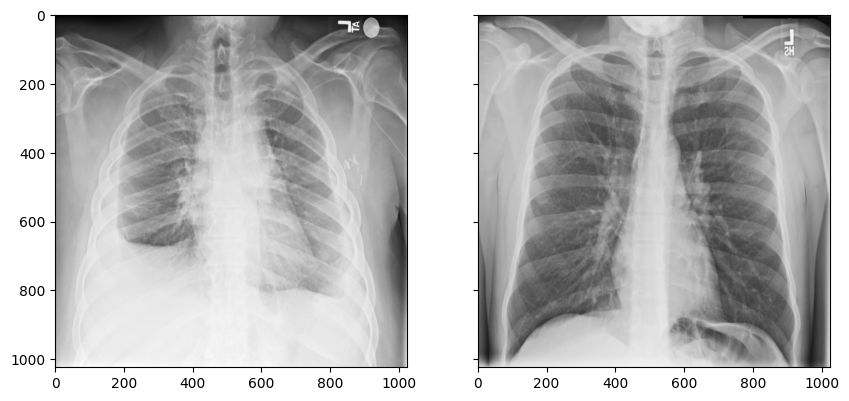

In [4]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [5]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')

    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

In [6]:
os.getcwd()

'/content'

In [7]:

import  resnet
img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [8]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'],
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode

        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})


        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [9]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=validation_generator)

1/1 [==============================] - 21s 21s/step - loss: 1.5024 - accuracy: 0.9355


In [10]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 22s 22s/step - loss: 2.3083 - accuracy: 0.1290
Epoch 2/5
1/1 [==============================] - 16s 16s/step - loss: 1.7489 - accuracy: 0.1290
Epoch 3/5
1/1 [==============================] - 16s 16s/step - loss: 1.5052 - accuracy: 0.8710
Epoch 4/5
1/1 [==============================] - 17s 17s/step - loss: 1.3890 - accuracy: 0.9032
Epoch 5/5
1/1 [==============================] - 17s 17s/step - loss: 1.3481 - accuracy: 0.9032


In [11]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [12]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
1/1 [==============================] - 5s 5s/step

Val AUC for epoch0: 0.3390804597701149
5/5 [==============================] - 104s 20s/step - loss: 1.4225 - accuracy: 0.8581 - val_loss: 2.3987 - val_accuracy: 0.9062 - val_auc: 0.3391
Epoch 2/5
1/1 [==============================] - 3s 3s/step

Val AUC for epoch1: 0.03225806451612902
5/5 [==============================] - 89s 18s/step - loss: 1.2765 - accuracy: 0.9091 - val_loss: 1.8670 - val_accuracy: 0.9062 - val_auc: 0.0323
Epoch 3/5
1/1 [==============================] - 4s 4s/step

Val AUC for epoch2: 0.4166666666666667
5/5 [==============================] - 96s 20s/step - loss: 1.2873 - accuracy: 0.8968 - val_loss: 1.2023 - val_accuracy: 0.9688 - val_auc: 0.4167
Epoch 4/5
1/1 [==============================] - 3s 3s/step

Val AUC for epoch3: 0.4482758620689655
5/5 [==============================] - 89s 18s/step - loss: 1.2693 - accuracy: 0.9032 - val_loss: 1.2573 - val_accuracy: 0.9375 - val_auc: 0.4483
Epoch 5/5
1/1 

In [13]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [14]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

1/1 [==============================] - 28s 28s/step - loss: 1.8417 - accuracy: 0.9032


**final** **run**

In [15]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []

    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [16]:
!mkdir models

In [17]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy', 'AUC'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
1/1 [==============================] - 3s 3s/step

Val AUC for epoch0: 0.33948863636363635

Epoch 1: val_auc improved from -inf to 0.33949, saving model to models/best_model.hdf5
13/13 [==============================] - 245s 18s/step - loss: 2.3352 - accuracy: 0.4112 - auc: 0.3966 - val_loss: 5.0738 - val_accuracy: 0.8958 - val_auc: 0.3395
Epoch 2/10
1/1 [==============================] - 3s 3s/step

Val AUC for epoch1: 0.37112299465240645

Epoch 2: val_auc improved from 0.33949 to 0.37112, saving model to models/best_model.hdf5
13/13 [==============================] - 238s 19s/step - loss: 2.2534 - accuracy: 0.5646 - auc: 0.5807 - val_loss: 2.2654 - val_accuracy: 0.8021 - val_auc: 0.3711
Epoch 3/10
1/1 [==============================] - 3s 3s/step

Val AUC for epoch2: 0.4303977272727273

Epoch 3: val_auc improved from 0.37112 to 0.43040, saving model to models/best_model.hdf5
13/13 [==============================] - 245s 19s/step - loss: 2.1473 - accuracy: 0.6516 - auc: 0.6

**Model Prediction**

In [18]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')


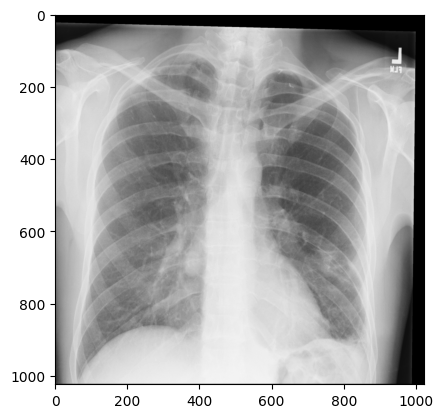

In [19]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-8])
plt.imshow(effusion,cmap='gray')

In [20]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

1/1 [==============================] - 0s 491ms/step


array([[0.1852643, 0.8147358]], dtype=float32)